# Test if PCA can separate the unique word2vec models

This notebook is designed to see if PCA can tease out unaligned word2vec models.
If it can then I wont have to explain UMAP but use PCA originally to do things.

In [1]:
import itertools
from pathlib import Path
import re

from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from sklearn.decomposition import PCA
import tqdm
import umap

# Unaligned Models

## Load the paths for each year

The goal here is to grab the odd years unaligned and see if umap can tease apart odd years.

In [2]:
unaligned_word_models = list(
    Path("../multi_model_experiment/output/models").rglob("*model")
)
unaligned_word_models = sorted(unaligned_word_models, key=lambda x: x.stem)
unaligned_word_model_filter = list(
    filter(lambda x: "2001" in x.stem, unaligned_word_models)
)

In [3]:
word_freq_count_cutoff = 5
odd_year_subset = unaligned_word_model_filter

In [4]:
training_unaligned_word_model_map = dict()
for word_file in tqdm.tqdm(odd_year_subset):
    model = Word2Vec.load(str(word_file)).wv
    training_unaligned_word_model_map[word_file.stem] = dict(
        model=model,
        cutoff_index=min(
            map(
                lambda x: 999999
                if model.get_vecattr(x[1], "count") > word_freq_count_cutoff
                else x[0],
                enumerate(model.index_to_key),
            )
        ),
    )

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


In [5]:
words_to_visualize = []
token_character_list = []
year_labels_list = []

In [6]:
for year in tqdm.tqdm(training_unaligned_word_model_map):
    model = training_unaligned_word_model_map[year]["model"]
    word_subset_matrix = model[
        model.index_to_key[: training_unaligned_word_model_map[year]["cutoff_index"]]
    ]
    print((year, word_subset_matrix.shape))
    words_to_visualize.append(word_subset_matrix)
    token_character_list += list(
        map(
            lambda x: re.escape(x),
            model.index_to_key[
                : training_unaligned_word_model_map[year]["cutoff_index"]
            ],
        )
    )
    year_labels_list += [year] * len(
        model.index_to_key[: training_unaligned_word_model_map[year]["cutoff_index"]]
    )

 70%|███████   | 7/10 [00:00<00:00, 29.87it/s]

('2001_0', (12092, 300))
('2001_1', (12092, 300))
('2001_2', (12092, 300))
('2001_3', (12092, 300))
('2001_4', (12092, 300))
('2001_5', (12092, 300))
('2001_6', (12092, 300))


100%|██████████| 10/10 [00:00<00:00, 30.05it/s]

('2001_7', (12092, 300))
('2001_8', (12092, 300))
('2001_9', (12092, 300))


In [7]:
training_unaligned_words = np.vstack(words_to_visualize)
training_unaligned_words

array([[ 4.31301355e-01,  7.92047009e-02, -3.09807688e-01, ...,
        -2.50414103e-01,  2.29236174e+00, -9.09666181e-01],
       [-1.30043900e+00, -1.23150915e-01,  6.98854625e-01, ...,
         5.68862438e-01,  1.74951100e+00,  1.13868438e-01],
       [-8.33079636e-01, -4.22711045e-01, -1.65444566e-03, ...,
        -2.13459983e-01,  1.12160802e+00, -1.28794801e+00],
       ...,
       [ 6.99581280e-02, -1.26659244e-01, -9.14445519e-02, ...,
         2.79934308e-03, -1.05758876e-01, -6.36764243e-02],
       [ 4.40234095e-02,  1.42163426e-01,  1.70036882e-01, ...,
        -2.16114596e-02,  8.74522403e-02,  3.15937884e-02],
       [-7.63052851e-02,  7.85519704e-02, -2.09962726e-02, ...,
         5.24048461e-03,  9.55198556e-02,  2.17113849e-02]], dtype=float32)

## Run PCA

In [8]:
model = PCA(n_components=2, random_state=100)
embeddings = model.fit_transform(training_unaligned_words)
transformed_df = pd.DataFrame(embeddings, columns=["pca1", "pca2"]) >> ply.define(
    year=year_labels_list, tok=token_character_list
)
transformed_df >> ply.slice_rows(10)

,pca1,pca2,year,tok
0,2.488523,-0.277072,2001_0,\
1,-2.294884,-0.547545,2001_0,the
2,-2.011507,0.477457,2001_0,of
3,0.657323,-2.073163,2001_0,","
4,-1.478790,-0.392996,2001_0,\.
5,0.114987,-0.125881,2001_0,and
6,-0.411530,-2.228736,2001_0,in
7,-0.230475,-2.744177,2001_0,\-
8,-5.067513,-0.852969,2001_0,to
9,-1.466520,0.167860,2001_0,a


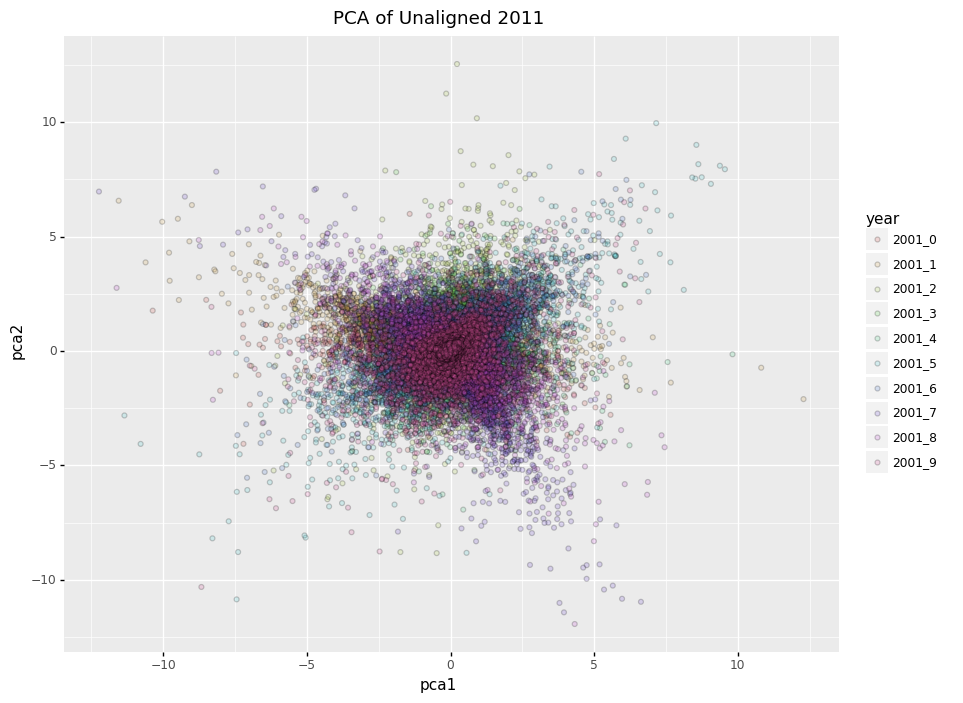

In [9]:
g = (
    p9.ggplot(
        transformed_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="pca1", y="pca2", fill="year"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.labs(title="PCA of Unaligned 2001")
    + p9.theme(figure_size=(10, 8))
)
print(g)

In [10]:
model = umap.parametric_umap.ParametricUMAP(
    verbose=True,
    metric="cosine",
    random_state=100,
    low_memory=True,
    n_neighbors=25,
    min_dist=0.0,
)
embedding = model.fit_transform(training_unaligned_words)

ParametricUMAP(optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fec0b8ed7b8>)


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/umap/parametric_umap.py:150: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.


Thu Feb 17 11:50:10 2022 Construct fuzzy simplicial set
Thu Feb 17 11:50:10 2022 Finding Nearest Neighbors
Thu Feb 17 11:50:10 2022 Building RP forest with 22 trees
Thu Feb 17 11:50:12 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Thu Feb 17 11:50:32 2022 Finished Nearest Neighbor Search
Thu Feb 17 11:50:34 2022 Construct embedding
Epoch 1/10
19957/19957 [==============================] - 121s 6ms/step - loss: 0.1484
Epoch 2/10
19957/19957 [==============================] - 112s 6ms/step - loss: 0.0949
Epoch 3/10
19957/19957 [==============================] - 112s 6ms/step - loss: 0.0915
Epoch 4/10
19957/19957 [==============================] - 111s 6ms/step - loss: 0.0902
Epoch 5/10
19957/19957 [==============================] - 111s 6ms/step - loss: 0.0894
Epoch 6/10
19957/19957 [==============================] - 111s 6ms/step - loss: 0.0890
Epoch 7/10
19957/19957 [==============================] - 

In [15]:
transformed_umap_df = pd.DataFrame(embedding, columns=["umap1", "umap2"]) >> ply.define(
    year=year_labels_list, tok=token_character_list
)
transformed_umap_df >> ply.slice_rows(10)

,umap1,umap2,year,tok
0,-6.456067,71.691856,2001_0,\
1,-5.161956,72.475128,2001_0,the
2,-5.252300,72.233032,2001_0,of
3,-38.163986,67.511917,2001_0,","
4,-5.854607,72.395508,2001_0,\.
5,-5.094406,71.892197,2001_0,and
6,-5.643434,71.619156,2001_0,in
7,-5.892644,71.450623,2001_0,\-
8,-5.465318,72.142899,2001_0,to
9,-5.594341,72.553123,2001_0,a


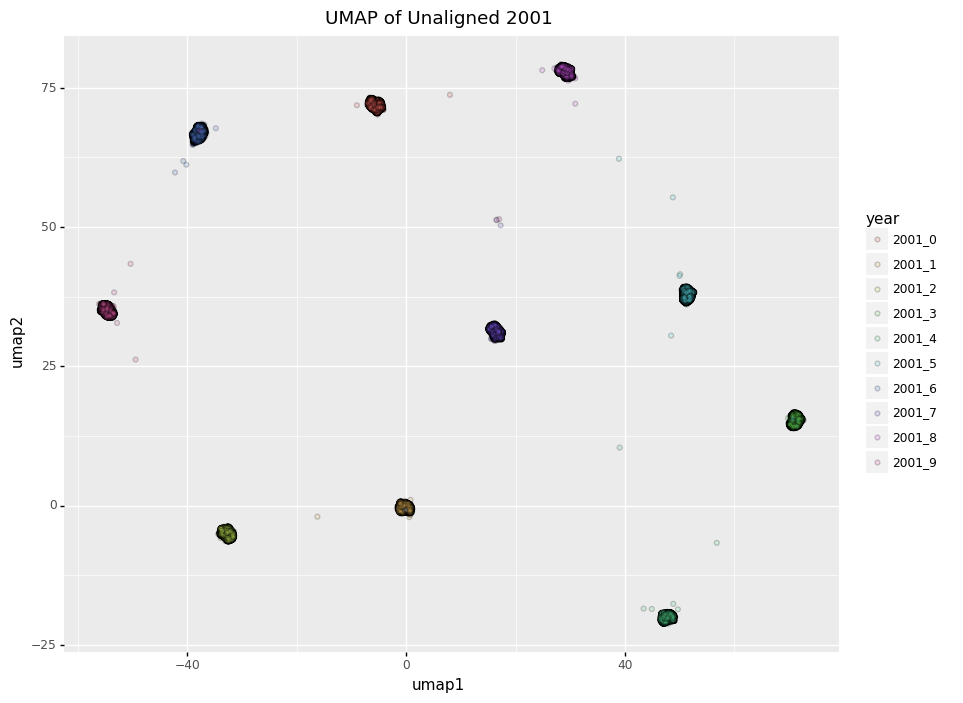

In [17]:
g = (
    p9.ggplot(
        transformed_umap_df >> ply.define(year="pd.Categorical(year)"),
        p9.aes(x="umap1", y="umap2", fill="year"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.labs(title="UMAP of Unaligned 2001")
    + p9.theme(figure_size=(10, 8))
)
print(g)

# Take home messages

1. Unfortunately PCA cannot tease apart years like UMAP can. Therefore, I'll have use UMAP moving forward.